## Book Recommenders 
#### using data from Book-Crossing: User review ratings

### Introduction

The purpose of this project is to build a book recommendation system for the users of a social network website "BookCrossing.com". There are about one million book review data collected from the website. The dataset contains detailed information about the books, such as the title, the author, the year of publication, and so on. It also has some demographic information on the users, such as age and location. More importantly, the dataset has information on each user's ratings on every book they have read on the website. Using both the content-based filtering (TF-IDF vectorization) and the collaborative filtering algorithms (KNN), I was able to build book recommendations based on the users' preferences. The future plan for the project is as follows: (i) fine-tune the parameters of the algorithms and perform various validation to examine the performance of the recommendation systems; (ii) build a book recommendation system using hybrid filtering, that is, to combine the content-based and collaborative filtering algorithms, and (iii) build a small application that recommends books for the users.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Import the data

In [2]:
#Users
u_cols = ['user_id', 'location', 'age']
users = pd.read_csv('../BookReview/Data/BX-Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False, skiprows=1)

#Books
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
items = pd.read_csv('../BookReview/Data/BX-Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False,skiprows=1)

#Ratings
r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv('../BookReview/Data/BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False,skiprows=1)

In [3]:
users.head()
items.head()
ratings.head()

user_id        isbn  rating
0   276725  034545104X       0
1   276726  0155061224       5
2   276727  0446520802       0
3   276729  052165615X       3
4   276729  0521795028       6

#### merge the datasets

In [4]:
df = pd.merge(users, ratings, on='user_id')
df = pd.merge(df, items, on='isbn')
df.head()

user_id                   location   age        isbn  rating  \
0        2  stockton, california, usa  18.0  0195153448       0   
1        8   timmins, ontario, canada   NaN  0002005018       5   
2    11400    ottawa, ontario, canada  49.0  0002005018       0   
3    11676              n/a, n/a, n/a   NaN  0002005018       8   
4    41385   sudbury, ontario, canada   NaN  0002005018       0   

            book_title           book_author year_of_publication  \
0  Classical Mythology    Mark P. O. Morford                2002   
1         Clara Callan  Richard Bruce Wright                2001   
2         Clara Callan  Richard Bruce Wright                2001   
3         Clara Callan  Richard Bruce Wright                2001   
4         Clara Callan  Richard Bruce Wright                2001   

                 publisher                                              img_s  \
0  Oxford University Press  http://images.amazon.com/images/P/0195153448.0...   
1    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
2    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
3    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
4    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   

                                               img_m  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0002005018.0...   
3  http://images.amazon.com/images/P/0002005018.0...   
4  http://images.amazon.com/images/P/0002005018.0...   

                                               img_l  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0002005018.0...  
3  http://images.amazon.com/images/P/0002005018.0...  
4  http://images.amazon.com/images/P/0002005018.0...

### 2. Data description

In [5]:
# dimension of the dataset
df.shape

(1031175, 12)

In [6]:
# number of users
df['user_id'].nunique()

92107

In [7]:
# number of books
df['isbn'].nunique()

270170

In [8]:
# summary statistics for numeric variables
df[['rating', 'age']].describe()

rating            age
count  1.031175e+06  753330.000000
mean   2.839022e+00      37.397719
std    3.854149e+00      14.098189
min    0.000000e+00       0.000000
25%    0.000000e+00      28.000000
50%    0.000000e+00      35.000000
75%    7.000000e+00      45.000000
max    1.000000e+01     244.000000

In [9]:
# max age = 244, might be an error. 
df.age[df['age'] <120].max()


118.0

### 2.1 Explore the books and authors

In [10]:
# number of books by year of publication (top ten years of most books published)
year_book = df.drop_duplicates(subset = ['year_of_publication', 'isbn'])[['year_of_publication', 'isbn']]
year_book.groupby(['year_of_publication'])['isbn'].count().reset_index(name="Number of Books").sort_values(by = "Number of Books", ascending=False).head(10)


year_of_publication  Number of Books
101                2002            17543
98                 1999            17342
100                2001            17265
99                 2000            17151
97                 1998            15700
96                 1997            14830
102                2003            14277
95                 1996            13975
94                 1995            13495
93                 1994            11739

In [11]:
# number of books by publisher
publisher_book = df.drop_duplicates(subset = ['publisher', 'isbn'])[['publisher', 'isbn']]
publisher_book.groupby(['publisher'])['isbn'].count().reset_index(name="Number of Books").sort_values(by = "Number of Books", ascending=False).head(10)


publisher  Number of Books
6574                  Harlequin             7524
13624                Silhouette             4190
11727                    Pocket             3896
1404           Ballantine Books             3775
1434               Bantam Books             3640
13220                Scholastic             3151
13669      Simon &amp; Schuster             2965
11356             Penguin Books             2833
1730   Berkley Publishing Group             2764
15878              Warner Books             2720

Text(0.5, 1.0, 'Top 10 books with most ratings')

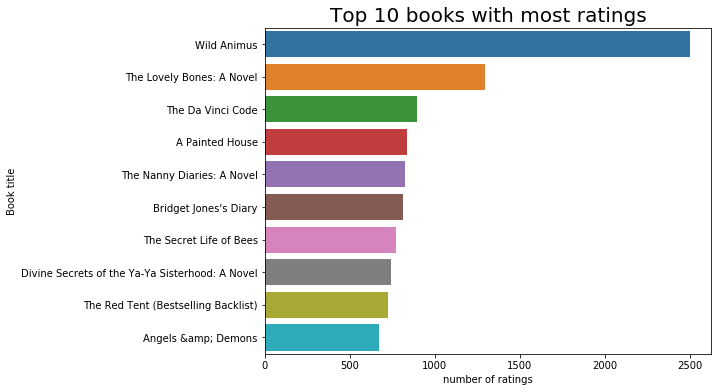

In [12]:
# Books with the most ratings
book_ratings = df.groupby(["book_title"])['user_id'].count().reset_index(name = 'number of ratings').sort_values(by = 'number of ratings', ascending = False)
Top10_book_ratings = book_ratings.head(10)

# draw a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x='number of ratings',y='book_title',data=Top10_book_ratings)
plt.ylabel('Book title')
plt.title('Top 10 books with most ratings', size=20)

In [13]:
# check the average number of ratings each book received: 3.82
# total number of ratings/total number of books
x = df.rating.count()
y = df.isbn.nunique()
x/y

3.8167635192656477

In [14]:
# books with the highest average ratings.
book_ave_ratings = df.groupby('book_title').agg(count=('isbn', 'count'), average_rating=('rating', 'mean')).reset_index()

# only focus on the books with at least 50 ratings
highest_rated_books = book_ave_ratings[book_ave_ratings['count'] >= 50].sort_values(by = 'average_rating', ascending = False).head(10)


Text(0.5, 1.0, 'Top 10 books with the highest average rating \n(on a scale of 0 to 10)')

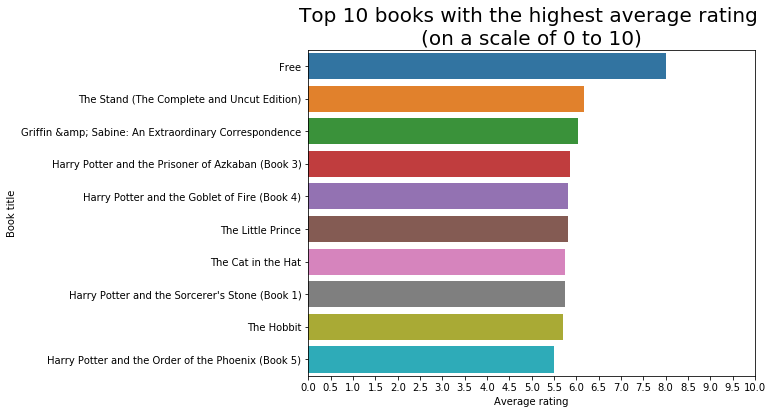

In [15]:
# create a bar plot for the books with the highest average rating
plt.figure(figsize=(8,6))
sns.barplot(x='average_rating',y='book_title', data = highest_rated_books)
plt.ylabel('Book title')
plt.xlabel('Average rating')
plt.xticks(np.arange(0, 10.5, 0.5))
plt.title('Top 10 books with the highest average rating \n(on a scale of 0 to 10)', size=20)

Text(0.5, 1.0, 'Top 10 authors with most ratings')

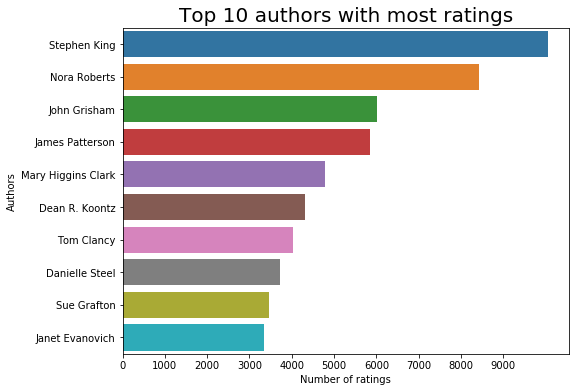

In [16]:
# authors with most ratings
author_ratings = df.groupby(["book_author"])['user_id'].count().reset_index(name = 'number of ratings').sort_values(by = 'number of ratings', ascending = False)
top_author_ratings = author_ratings.head(10)

# plot a barchart for the top 10 authors with most ratings
plt.figure(figsize=(8,6))
sns.barplot(x='number of ratings',y='book_author', data = top_author_ratings)
plt.ylabel('Authors')
plt.xlabel('Number of ratings')
plt.xticks(np.arange(0, 10000, 1000))
plt.title('Top 10 authors with most ratings', size=20)


In [17]:
# creat a worldcloud for the famous authors (i.e. authors with most ratings)
!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS
stop_words=set(STOPWORDS)

author_string = " ".join(df['book_author'].astype(str))

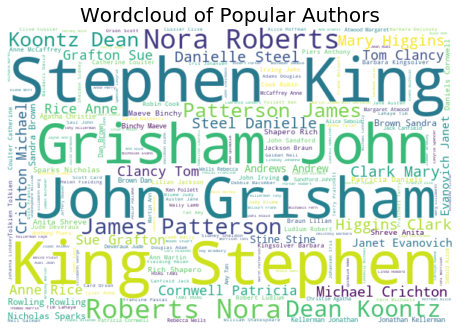

In [68]:
wc = WordCloud(width=600,height=400, max_font_size=90,stopwords=stop_words,background_color='white').generate(author_string)

fig=plt.figure(figsize=(8,6))
plt.axis('off')
plt.title('Wordcloud of Popular Authors',size=20)
plt.imshow(wc, interpolation='bilinear') # interpolation = 'bilinear' to make the displayed image appear more smoothly





In [62]:
# authors with the highest average rating.
author_rating = df.groupby('book_author').agg(count=('isbn', 'count'), average_rating=('rating', 'mean')).reset_index()

# average number of ratings per author (aaverage number of ratings per author: 10.15)
author_rating['count'].mean()

# limited to authors with at least 50 ratings
top_author_rating = author_rating[author_rating['count'] >= 50].sort_values(by = 'average_rating', ascending = False).head(10)



Text(0.5, 1.0, 'Top 10 authors with the highest average rating')

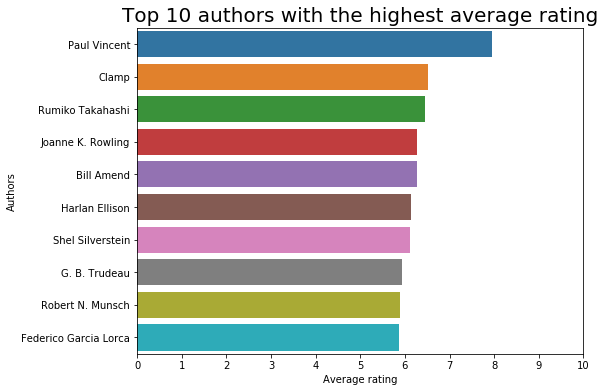

In [20]:
# plot a bar chart for top 10 authors with the highest average rating
plt.figure(figsize=(8,6))
sns.barplot(x='average_rating',y='book_author', data = top_author_rating)
plt.ylabel('Authors')
plt.xlabel('Average rating')
plt.xticks(np.arange(0, 11, 1))
plt.title('Top 10 authors with the highest average rating', size=20)


### 2.2 Explore the users 

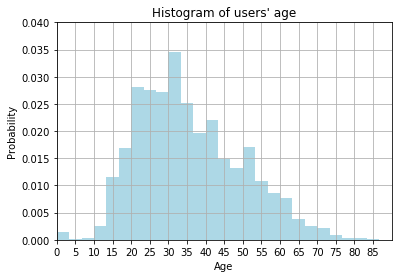

In [21]:
# the age distribution of the users

age_trunc = df[df['age'] <= 100]

# drop the duplicated users
age_trunc = age_trunc.drop_duplicates(subset = ['user_id'])['age']

# sns.distplot(age_trunc, bins=30, kde=True)

plt.hist(age_trunc, 30, density=True, facecolor='lightblue', alpha=1)
plt.xlabel('Age')
plt.ylabel('Probability')
plt.title('Histogram of users\' age')
plt.xlim(0,90)
x_ticks = np.arange(0, 90, 5)
plt.xticks(x_ticks)
plt.ylim(0, 0.04)
plt.grid(True)
plt.show()

In [22]:
# the location (country) of the users

# split the location into city, state, and country
df[['city','state','country']] = df["location"].str.split(", ", expand=True, n=2) 

# drop the duplicated users
users = df.drop_duplicates(subset = ['user_id'])


country = users.groupby('country')['user_id'].count().reset_index(name = 'count') 


In [23]:
# drop the countries with less than 1000 users
country2 = country[country['count'] >500 ]

In [24]:
# plot a pie chart to show where do the users come from. 
import plotly.express as px
fig = px.pie(country2,
             values="count",
             names="country",
             title="Home country of users",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()


In [25]:
# Where do the US users come from? (state)

US_users = users[users.country == "usa"]
state = US_users.groupby('state')['user_id'].count().reset_index(name = 'count') 
state2 = state[state['count'] > 1500]

fig = px.pie(state2,
             values="count",
             names="state",
             title="Location (state) of the US users",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()


In [26]:
# Where do the US users come from? (city)

city = US_users.groupby('city')['user_id'].count().reset_index(name = 'count') 
city2 = city[city['count'] > 250]

fig = px.pie(city2,
             values="count",
             names="city",
             title="Location(city) of the US users",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()


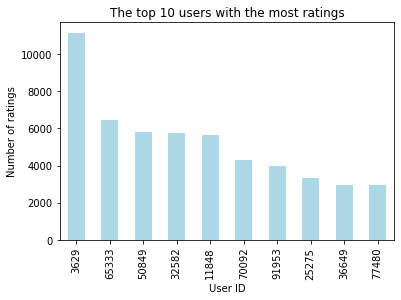

In [27]:
# The top 10 users with the most ratings.
user_rating = df.groupby('user_id')['user_id'].count().reset_index(name = 'number of ratings').sort_values(by = 'number of ratings', ascending = False)
top10_users = user_rating.head(10)

# plot a bar chart
top10_users['number of ratings'].plot.bar(x='User ID', y='Number of ratings', color = 'lightblue')

# Add title and axis names
plt.title('The top 10 users with the most ratings')
plt.xlabel('User ID')
plt.ylabel('Number of ratings')
plt.show()


### 3. Book recommender

### 3.1 Collaborative Filtering (item-based)

### Data Processing 

In [28]:
mydf = df[['user_id', 'book_title', 'rating']]

# drop duplicates
mydf = mydf.drop_duplicates(subset = ['user_id', 'book_title'])

# I consider 'rating = 0' as a valid rating
# 382,203 observations with rating > 0
# 644,194 observations with rating = 0

To get an idea about a user’s preference, we need a user who’s rated at least 5 books. Similarly, to derive predictions regarding book recommendations, we need books that have been rated at least 5 times.

In [29]:
# restrict to books with at least five ratings (quality books)
books = mydf['book_title'].value_counts().rename_axis('book_title').reset_index(name = 'count')
books = books[books['count']>5]['book_title'].to_list()
quality_rating = mydf[mydf['book_title'].isin(books)]


In [30]:
# restric to users with at least 5 ratings (quality users)
users = mydf['user_id'].value_counts().rename_axis('user_id').reset_index(name = 'count')
users = users[users['count']>5]['user_id'].to_list()
quality_rating = quality_rating[quality_rating['user_id'].isin(users)]


In [31]:
quality_rating.head()
# No. of observations reduced from 1,026,397 to 585,687

user_id    book_title  rating
1        8  Clara Callan       5
2    11400  Clara Callan       0
3    11676  Clara Callan       8
4    41385  Clara Callan       0
5    67544  Clara Callan       8

In [32]:
# there is no missing value
quality_rating.isnull().sum()

user_id       0
book_title    0
rating        0
dtype: int64

Some users may be tougher than the others, that is, they tend to always give ratings lower than the average. So we need to bring all users to the same level by removing their bias. I subtract the average rating given by each user to all books from each book rated by that user (i.e. demeaning). By doing this, we have changed the value of average rating given by every user to 0, which brings them all to the same level and remove their bias. 

In [33]:
# demeaning the data

quality_rating['trans_rating'] = quality_rating['rating'] - quality_rating.groupby('user_id')['rating'].transform('mean')

When converting to pivot table, we are working with an extremely sparse matrix. We fill the missing values with 0. 

In [34]:
# pivot table
book_ratings = pd.pivot_table(quality_rating, index = 'book_title', columns = 'user_id', values = 'trans_rating', fill_value=0)

A lot of values in the pivot table are zero. Thus, we’re dealing with extremely sparse data. In such a case, we need to work with a scipy-sparse matrix to avoid overflow and wasted memory.

In [ ]:
# transform to scipy-sparse matrix

from scipy.sparse import csr_matrix
book_ratings_sparse = csr_matrix(book_ratings)

### Applying the KNN Algorithm

In [50]:
from sklearn.neighbors import NearestNeighbors

#make an object for the NearestNeighbors Class.
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)

# fit the dataset
model_knn.fit(book_ratings_sparse)
#distances, indices = model_knn.kneighbors(book_ratings_sparse)


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                 radius=1.0)

### Making recommendations

In [51]:
# get the list of book titles 
book_titles = book_ratings.index.to_list()

# get the cover image of the books
book_cover = items[items['book_title'].isin(books)]['img_m']

# valid book titles
titles = quality_rating.drop_duplicates(subset = 'book_title')

# all books with images in the original book data
all_books = items.drop_duplicates(subset = 'book_title')

# merge with the original book data
merged_book = pd.merge(all_books, titles, on = 'book_title', how='right')

merged_book = merged_book.sort_values(by = 'book_title')



In [69]:
from IPython.display import Image
from skimage import io


def make_recommendation(model_knn, data, fav_book, n_recommendations):
    
    # fit the model
    model_knn.fit(data)
    
    query_index = book_titles.index(fav_book)
    
    distances, indices = model_knn.kneighbors(data[query_index], n_neighbors=n_recommendations+1)
    
    raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[1:]
    
    
    print('You have input book:', fav_book)
    print('Recommendation system starts to make inference')
    print('......\n')
    
    print('Recommendations for {}:'.format(fav_book))
    for i, (idx, dist) in enumerate(raw_recommends):
        #url = merged_book.iloc[idx]['img_m']
        
        print('{0}: {1}'.format(i+1, book_titles[idx]))
        #print('{0}: {1}, with distance of {2}'.format(i+1, book_titles[idx], dist))
        #io.imshow(io.imread(url))
        #io.show()



In [73]:
# Example 1
my_book = 'The Little Prince'
make_recommendation(model_knn, book_ratings_sparse, my_book, 5)
    

You have input book: The Little Prince
Recommendation system starts to make inference
......

Recommendations for The Little Prince:
1: Life Strategies for Teens
2: Just Between Us . . .   Kiss &amp; Tell (Harlequin Blaze)
3: The Birds and the Bees
4: Baby Doctor  (Emergency) (Harlequin Superromance, No 753)
5: In Name Only (Texas Grooms) (Desire, 1313)


You have input book: Harry Potter and the Goblet of Fire (Book 4)
Recommendation system starts to make inference
......

Recommendations for Harry Potter and the Goblet of Fire (Book 4):
1: Harry Potter and the Prisoner of Azkaban (Book 3), with distance of 0.5502615797063404


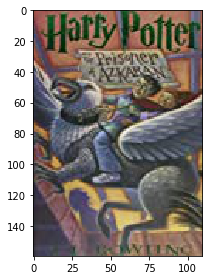

2: Harry Potter and the Chamber of Secrets (Book 2), with distance of 0.6321323360572636


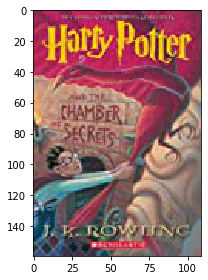

3: Harry Potter and the Order of the Phoenix (Book 5), with distance of 0.6968846897538532


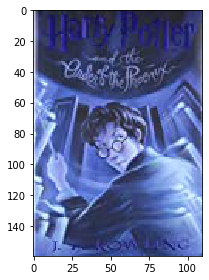

4: Harry Potter and the Sorcerer's Stone (Book 1), with distance of 0.7281455899104569


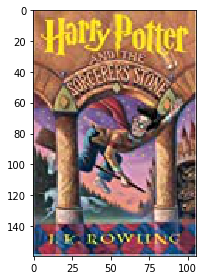

5: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), with distance of 0.8464401445895224


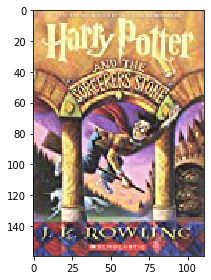

In [59]:
# Example 2
my_book = 'Harry Potter and the Goblet of Fire (Book 4)'
make_recommendation(model_knn, book_ratings_sparse, my_book, 5)
    

### 3.2 Content-based Filtering

We do not have detailed information about the content of the books, such as genre, or content description. The only information we might use is the title of the books. 

### Creating a TF-IDF vectorizer

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
titles = merged_book['book_title']
vectorizer = TfidfVectorizer(analyzer='word',  stop_words='english')
tfidf_matrix = vectorizer.fit_transform(titles)

tfidf_matrix.shape  # 31,630 books with 19,263 words in the titles (bag of words)

The tfidf_matrix is the matrix containing each word and its TF-IDF score with regard to each book title. Also, stop words are simply words that add no significant value to our system, like ‘an’, ‘is’, ‘the’, and hence are ignored by the system. Now, we have a representation of every book in terms of the words of the titles. Next, we need to calculate the relevance or similarity of one book to another.

### Calculating Cosine similarity

In [ ]:
from sklearn.metrics.pairwise import linear_kernel 

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix) 
cosine_similarities.shape

In [ ]:
cosine_similarities[0] # the first row

In [ ]:
results = {}
for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1] 
    similar_items = [(cosine_similarities[idx][i], ds['id'][i]) for i in similar_indices] 
    results[row['id']] = similar_items[1:]


In [ ]:
# vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english')
# vectors = vectorizer.fit_transform(corpus)
# feature_names = vectorizer.get_feature_names()
# dense = vectors.todense()
# denselist = dense.tolist()
# df = pd.DataFrame(denselist, columns=feature_names)
# df